# Librairies

In [1]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import aic
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit


# Collecte et préparation des données
## Collecte des données

In [2]:
# get s&p 500 closing prices and volume for the last 5 years
sp500 = yf.Ticker("^GSPC").history(period="5y", interval="1d")[["Close", "Volume"]]
sp500.columns = ["sp500_close", "sp500_volume"]
sp500.index = sp500.index.strftime('%Y-%m-%d')

# get VIX closing prices
vix = yf.Ticker("^VIX").history(period="5y", interval="1d")["Close"]
vix.index = vix.index.strftime('%Y-%m-%d')
vix.name = "vix_close"

In [3]:
# get interest rates from FRED for the last 5 years
end = datetime.datetime.now()
start = end - datetime.timedelta(days=5*365)

dict_maturities={}
maturities = [1/12, 0.25, 0.5,1,2,3,5,7,10,20,30]
for i in maturities:
    if(i<1):
        dict_maturities[str(int(i*12))+'M']='DGS'+str(int(i*12))+'MO'
    else:
        dict_maturities[str(i)+'Y']='DGS'+str(i)

data_ir = pd.DataFrame()
for key, series_id in dict_maturities.items():
    data_ir[key] = pdr.get_data_fred(series_id, start, end)
data_ir = data_ir.dropna()/100    #we delete the dates with missing values and convert to percentage
data_ir.index = data_ir.index.strftime('%Y-%m-%d')

In [4]:
df = sp500.merge(vix, left_index=True, right_index=True)
df = df.merge(data_ir, left_index=True, right_index=True)

## Prétraitement des données

In [5]:
# log returns
df["sp500_log_return"] = np.log(df["sp500_close"] / df["sp500_close"].shift(1))
df.dropna(inplace=True)

<Axes: >

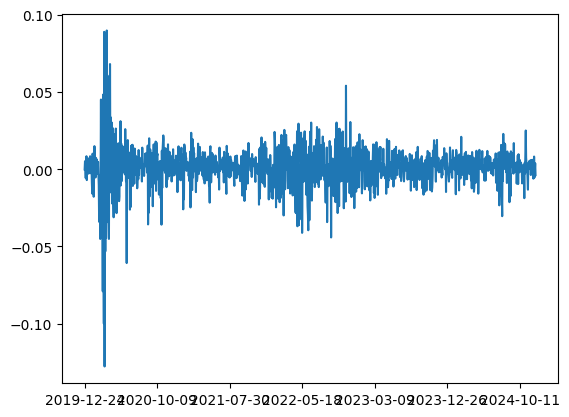

In [6]:
df["sp500_log_return"].plot()

La série des log-returns parait stationnaire mais nous allons le vérifier avec un test de Dickey-Fuller.

In [7]:
# 1. Test ADF (Augmented Dickey-Fuller)
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("La série est stationnaire (p-value <= 0.05)")
    else:
        print("La série n'est pas stationnaire (p-value > 0.05)")

adf_test(df["sp500_log_return"])

# 2. Déterminer les décalages temporels pertinents avec ARIMA
# Ici, nous utilisons un modèle ARIMA avec différents ordres de p, d, q
# Le critère AIC sera utilisé pour déterminer l'ordre optimal.

def find_best_arima_order(series):
    series.reset_index(drop=True, inplace=True)
    best_aic = np.inf
    best_order = None
    # create an orders list such that the model is stationary
    orders_list = [(0,0), (0,1), (0,2), (0,3), (0,4), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2), (3,0), (3,1), (3,2), (4,0), (4,1), (4,2)]
    for p,q in orders_list:
        try:
            model = ARIMA(series, order=(p,0,q))
            model_fit = model.fit()
            aic_value = model_fit.aic
            if aic_value < best_aic:
                best_aic = aic_value
                best_order = (p,q)
        except Exception as e:
            continue
    print(f"L'ordre optimal pour ARIMA est: {best_order} avec AIC = {best_aic}")

find_best_arima_order(df["sp500_log_return"])


ADF Statistic: -10.646993319983778
p-value: 4.767476993501795e-19
La série est stationnaire (p-value <= 0.05)


/home/yohann/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yohann/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yohann/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yohann/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yohann/miniconda3/lib/python3.12/site-packages/statsmo

L'ordre optimal pour ARIMA est: (3, 2) avec AIC = -7263.139674467109


Les log-returns étant stationnaires, ils seront plus faciles à prédire donc nous allons nous focaliser sur eux.

## Feature engineering

In [7]:
df['EMA12'] = df['sp500_log_return'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['sp500_log_return'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [8]:
# Relative strength index
def rsi(series, period):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI_10'] = rsi(df['sp500_close'], 10)
df['RSI_22'] = rsi(df['sp500_close'], 22)

In [10]:
df.dropna(inplace=True)

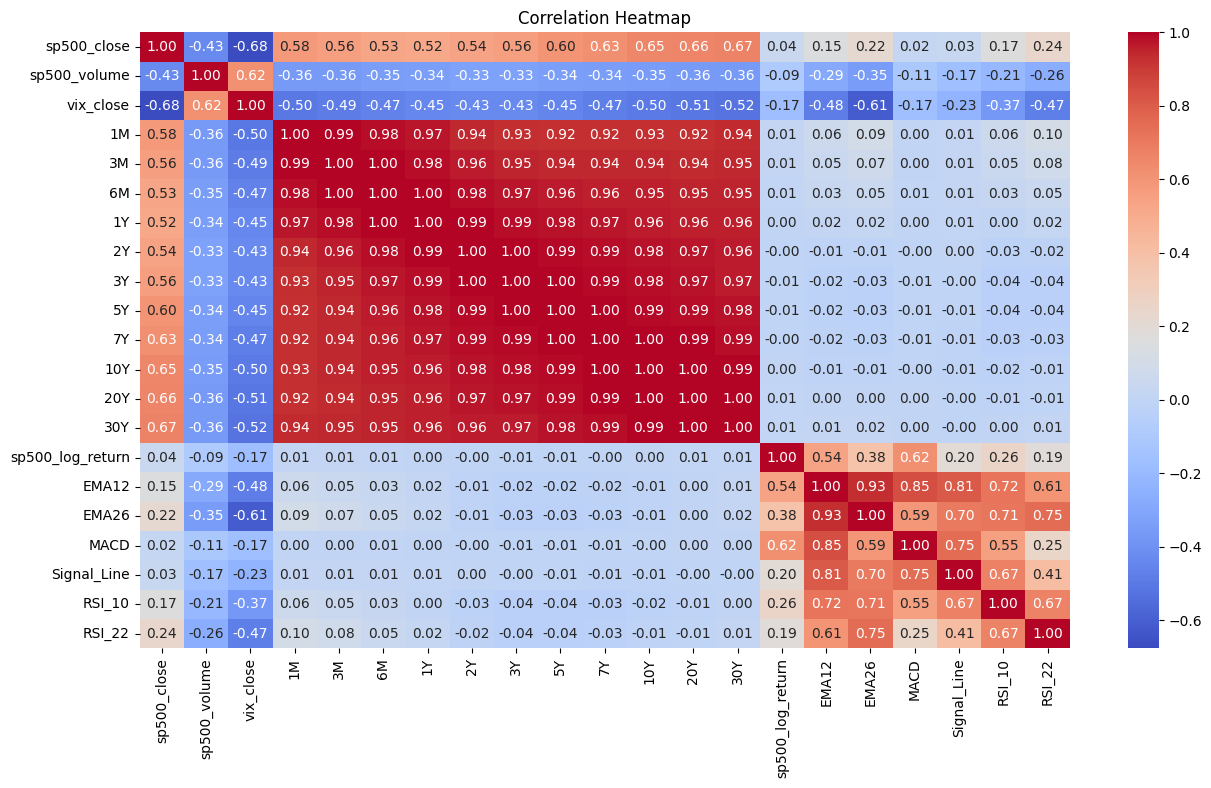

In [11]:
# create a heatmap to visualize the correlation between the features
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

Toutes les colonnes de taux d'intérêts sont très corrélées entre elles, nous décidons de ne garder que les taux à un mois. Les deux colonnes EMA sont également très corrélées donc nous ne gardons que EMA26.

In [12]:
df.drop(["3M", "6M", "1Y", "2Y", "3Y", "5Y", "7Y", "10Y", "20Y", "30Y", "EMA12"], axis=1, inplace=True)

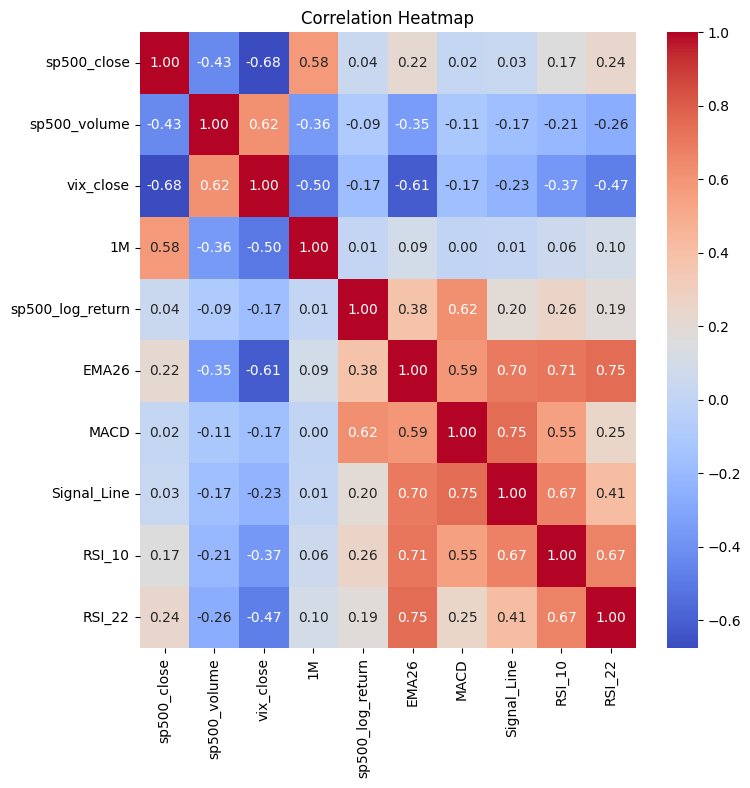

In [15]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

features selection à implémenter

# Développement du modèle prédictif

In [16]:
def backtest(df, model_type, n_splits=20):
    # Lists to store results
    mae_errors = []
    rmse_errors = []
    preds=[]
    true_values=[]

    df['y'] = df['sp500_log_return'].shift(-len(df)//n_splits)
    df.dropna(inplace=True)
    X = df.drop('y', axis=1)
    y = df['y']

    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    if model_type == 'linear regression':
        model = LinearRegression()
    elif model_type == 'random forest':
        model = RandomForestRegressor(n_estimators=100, random_state=0)
    else:
        raise ValueError("Model type must be either 'linear regression' or 'random forest'")
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        true_values.extend(y_test)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        preds.extend(y_pred)
        
        mae_errors.append(mean_absolute_error(y_test, y_pred))
        rmse_errors.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    return mae_errors, rmse_errors, preds, true_values
    

In [17]:
lr_mae_errors, lr_rmse_errors, lr_preds, lr_tv = backtest(df, "linear regression")

# Print the errors for each fold
print("Linear regression: Mean of MAE:", np.mean(lr_mae_errors))
print("Linear regression: Mean of RMSE:", np.mean(lr_rmse_errors))

rf_mae_errors, rf_rmse_errors, rf_preds, rf_tv = backtest(df, "random forest")

# Print the errors for each fold
print("Random forest: Mean of MAE:", np.mean(rf_mae_errors))
print("Random forest: Mean of RMSE:", np.mean(rf_rmse_errors))

Linear regression: Mean of MAE: 0.008055112814139549
Linear regression: Mean of RMSE: 0.01018682578330191
Random forest: Mean of MAE: 0.008513637796771247
Random forest: Mean of RMSE: 0.010795285250074036


add ARIMA, random forest / xgboost (and LSTM)

# Analyse des résultats et interprétation

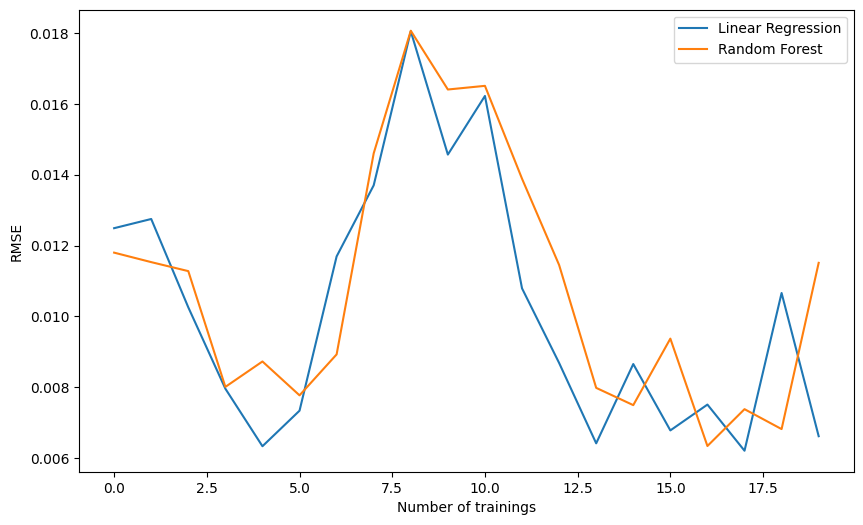

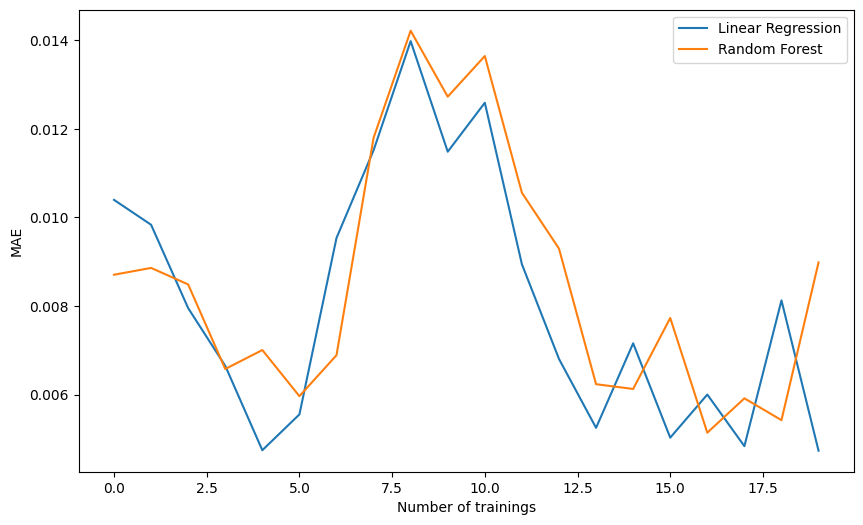

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(lr_rmse_errors, label="Linear Regression")
plt.plot(rf_rmse_errors, label="Random Forest")
plt.xlabel("Number of trainings")
plt.ylabel("RMSE")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(lr_mae_errors, label="Linear Regression")
plt.plot(rf_mae_errors, label="Random Forest")
plt.xlabel("Number of trainings")
plt.ylabel("MAE")
plt.legend()
plt.show()

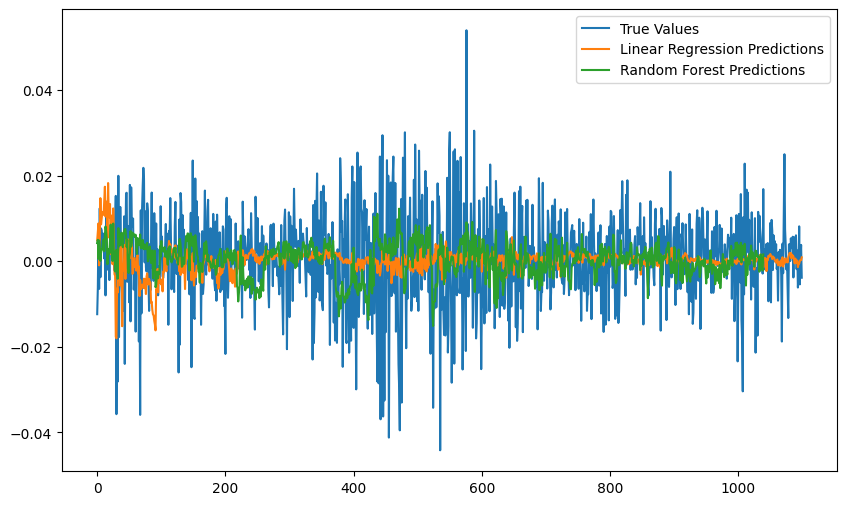

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(lr_tv, label="True Values")
plt.plot(lr_preds, label="Linear Regression Predictions")
plt.plot(rf_preds, label="Random Forest Predictions")
plt.legend()
plt.show()

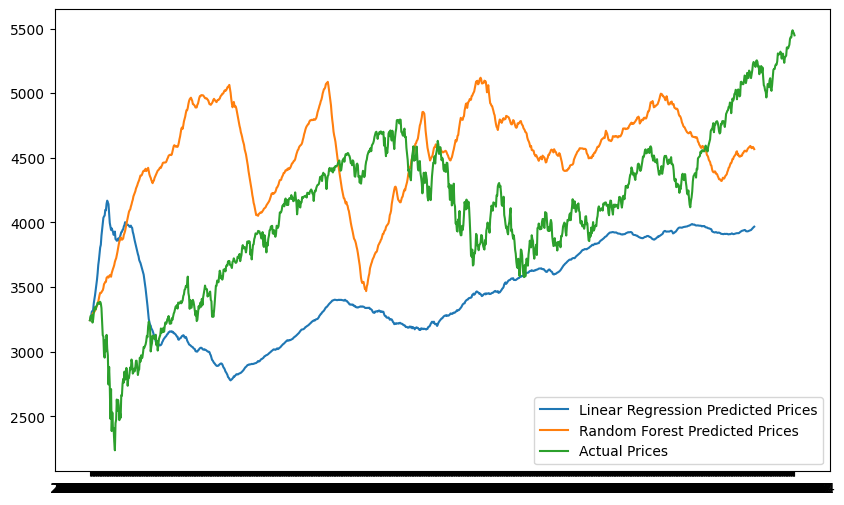

In [23]:
# compute sp500 prices from log returns
lr_pred_prices = [df["sp500_close"].iloc[0]]
rf_pred_prices = [df["sp500_close"].iloc[0]]
tp = [df["sp500_close"].iloc[0]]
for i in range(1, len(rf_preds)):
    lr_pred_prices.append(lr_pred_prices[-1] * np.exp(lr_preds[i-1]))
    rf_pred_prices.append(rf_pred_prices[-1] * np.exp(rf_preds[i-1]))
    tp.append(tp[-1] * np.exp(df["sp500_log_return"].iloc[i-1]))

plt.figure(figsize=(10, 6))
plt.plot(lr_pred_prices, label="Linear Regression Predicted Prices")
plt.plot(rf_pred_prices, label="Random Forest Predicted Prices")
plt.plot(df["sp500_close"], label="Actual Prices")
#plt.plot(tp, label="True Prices")
plt.legend()
plt.show()